In [84]:
#!pip install cufflinks
#!pip install textblob 
#!pip install wordcloud 
#!pip install vaderSentiment

In [85]:
import numpy as np
import pandas as pd
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cufflinks as cf
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = True)
cf.go_offline();
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option("display.max_columns", None)

In [86]:
df = pd.read_csv("amazon.csv")
df.sort_values("wilson_lower_bound", ascending=False, inplace=True)
df.drop("Unnamed: 0", inplace=True, axis=1)

### Missing Values & Plotting

In [87]:
def missing_values_analysis(df):
  na_columns_ = [col for col in df.columns if df[col].isnull().sum() > 0] # ['reviewerName', 'reviewText']
  n_miss = df[na_columns_].isnull().sum().sort_values(ascending=True)
  ratio_ = (df[na_columns_].isnull().sum() / df.shape[0]*100)
  missing_df = pd.concat([n_miss, np.round(ratio_, 2)], axis=1, keys=["Missing Values", "Ratio"])
  #missing_df = pd.DataFrame(missing_df)
  return missing_df

def check_dataframe(df, head=5, tail=5):
  print("SHAPE".center(52, '~'))
  print(f"Rows: {df.shape[0]}")
  print(f"Columns: {df.shape[1]}")
  print("TYPES".center(52, '~'))
  print(df.dtypes)
  print("".center(52, '~'))
  print(missing_values_analysis(df))
  print("DUPLICATED VALUES".center(52, '~'))
  print(df.duplicated().sum())
  print("QUANTITILES".center(52, '~'))
  print(df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

def check_uniqueness(df):
  nunique_df = pd.DataFrame({'Variable': df.columns,
                             'Classes': [df[i].nunique() for i in df.columns]})
  nunique_df.sort_values('Classes', ascending=False, inplace=True)
  nunique_df.reset_index(drop=True, inplace=True)
  return nunique_df

check_dataframe(df)
print("UNIQUENESS".center(52, '~'))
print(check_uniqueness(df))

~~~~~~~~~~~~~~~~~~~~~~~SHAPE~~~~~~~~~~~~~~~~~~~~~~~~
Rows: 4915
Columns: 11
~~~~~~~~~~~~~~~~~~~~~~~TYPES~~~~~~~~~~~~~~~~~~~~~~~~
reviewerName             object
overall                   int64
reviewText               object
reviewTime               object
day_diff                  int64
helpful_yes               int64
helpful_no                int64
total_vote                int64
score_pos_neg_diff        int64
score_average_rating    float64
wilson_lower_bound      float64
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              Missing Values  Ratio
reviewerName               1   0.02
reviewText                 1   0.02
~~~~~~~~~~~~~~~~~DUPLICATED VALUES~~~~~~~~~~~~~~~~~~
0
~~~~~~~~~~~~~~~~~~~~QUANTITILES~~~~~~~~~~~~~~~~~~~~~
                       0.00  0.05   0.50        0.95       0.99         1.00
overall                 1.0   2.0    5.0    5.000000    5.00000     5.000000
day_diff                1.0  98.0  431.0  748.000000  943.00000  1064.000000
helpf

### Categorical Variable Analysis

In [88]:
constraints = ["#B34D22", "#EBE00C", "#1FEB0C", "#0C92EB", "#EB0CD5"]
def categorical_variable_summary(df, column_name="overall"):
  fig = make_subplots(rows = 1, cols=2, 
                      subplot_titles=('Countplot', 'Percentage'), 
                      specs=[[{'type':"xy"},{'type':"domain"}]])
  
  fig.add_trace(go.Bar(y = df[column_name].value_counts().values.tolist(),
                       x = [str(i) for i in df[column_name].value_counts().index],
                       text = df[column_name].value_counts().values.tolist(),
                       textfont = dict(size=14),
                       name = column_name,
                       textposition = 'auto',
                       showlegend = False,
                       marker = dict(color=constraints,
                                     line=dict(color='#DBE6EC', width=1))),
                row = 1, col = 1)
  
  fig.add_trace(go.Pie(labels=df[column_name].value_counts().keys(),
                       values=df[column_name].value_counts().values,
                       textfont = dict(size=18),
                       name = column_name,
                       textposition = 'auto',
                       showlegend = False,
                       marker = dict(colors=constraints)),
                row = 1, col = 2)
  
  fig.update_layout(title={'text': column_name, 
                           'y':0.9, 'x':0.5, 
                           'xanchor':"center", 'yanchor':'top'},
                           template='plotly_white')
  iplot(fig)
    
    
categorical_variable_summary(df, "overall")

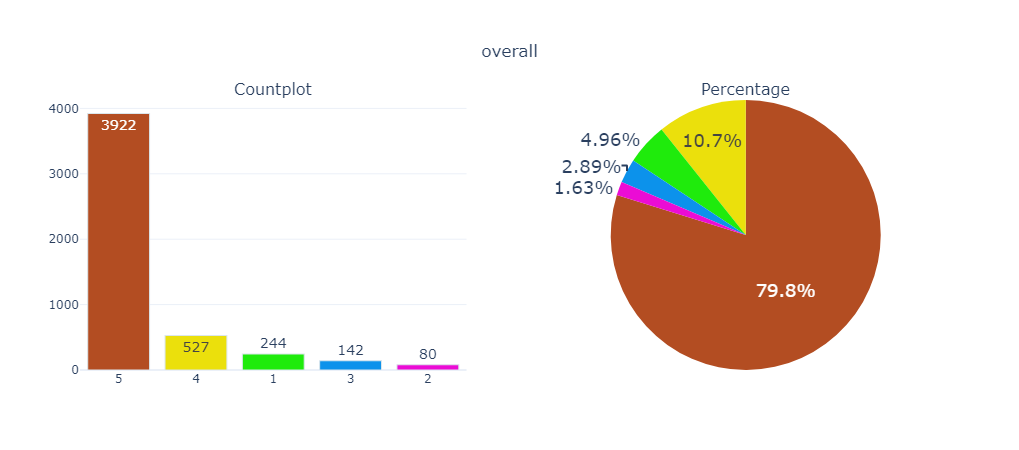

In [94]:
from IPython.display import Image
Image(filename='newplot.png') 

### Structing the ReviewText with regular Expressions

In [89]:
restructing_text = lambda x: re.sub("[^a-zA-Z]", " ", str(x))
df["reviewText"] = df["reviewText"].map(restructing_text)
df["reviewText"] = df["reviewText"].str.lower()

### Performing Sentiment Analysis

In [90]:
df[['polarity', 'subjectivity']] = df['reviewText'].apply(lambda Text:pd.Series(TextBlob(Text).sentiment))
for idx, row in df['reviewText'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    if neg > pos:
        df.loc[idx, 'sentiment'] = "Negative"
    elif neg < pos:
        df.loc[idx, 'sentiment'] = "positive"
    else:
        df.loc[idx, 'sentiment'] = "Neutral"

In [91]:
categorical_variable_summary(df, "sentiment")

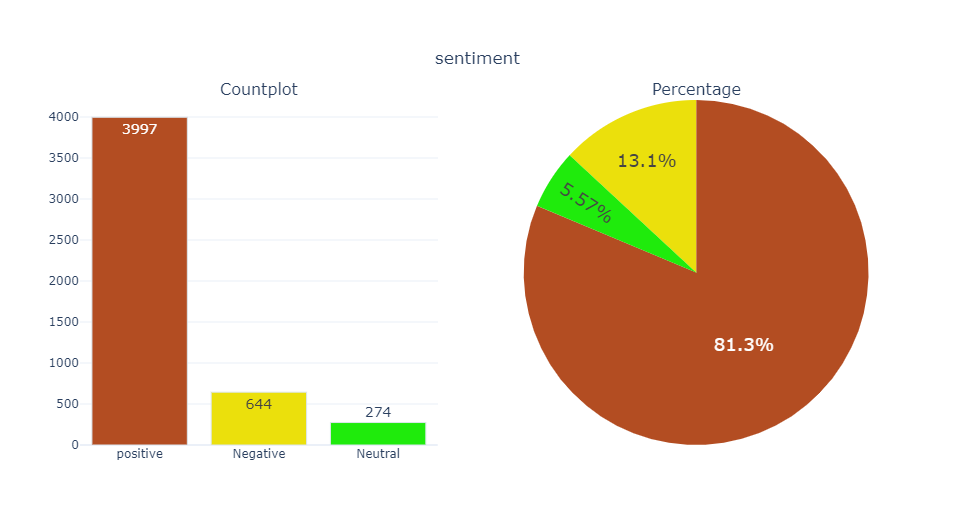

In [93]:
Image(filename='final.png') 

###### Credits: https://www.youtube.com/watch?v=SMecj9AIDF8